# LSTM Model Inference - NSL-KDD

This notebook tests the trained LSTM model for Network Intrusion Detection on the NSL-KDD test dataset.

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 1. Model Definition

In [2]:
class ImprovedLSTMClassifier(nn.Module):
    """
    Bidirectional LSTM for Network Intrusion Detection.
    
    Architecture:
    - Input BatchNorm + Linear embedding
    - 3-layer Bidirectional LSTM (256 hidden units)
    - Classification head with BatchNorm and Dropout
    """
    
    def __init__(self, input_dim, num_classes=2, hidden_dim=256, 
                 num_layers=3, dropout=0.4, bidirectional=True):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        # Feature embedding
        self.input_bn = nn.BatchNorm1d(input_dim)
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_dim * self.num_directions),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * self.num_directions, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = self.input_bn(x)
        x = torch.relu(self.input_fc(x))
        x = x.unsqueeze(1)  # (batch, 1, features)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        return self.classifier(x)

print("✅ Model class defined!")

✅ Model class defined!


## 2. Load Data

In [3]:
# Column names for NSL-KDD
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Binary classification mapping
ATTACK_MAPPING = {
    'normal': 0,
    'back': 1, 'land': 1, 'neptune': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 1, 'nmap': 1, 'portsweep': 1, 'satan': 1, 'mscan': 1, 'saint': 1,
    'ftp_write': 1, 'guess_passwd': 1, 'imap': 1, 'multihop': 1, 'phf': 1,
    'spy': 1, 'warezclient': 1, 'warezmaster': 1, 'sendmail': 1, 'named': 1,
    'snmpgetattack': 1, 'snmpguess': 1, 'xlock': 1, 'xsnoop': 1, 'worm': 1,
    'buffer_overflow': 1, 'loadmodule': 1, 'perl': 1, 'rootkit': 1,
    'httptunnel': 1, 'ps': 1, 'sqlattack': 1, 'xterm': 1,
}

# Load data
DATA_PATH = Path('../../data/raw/nsl-kdd/')
train_df = pd.read_csv(DATA_PATH / 'train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv(DATA_PATH / 'test.txt', header=None, names=COLUMNS)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Training samples: 125,973
Test samples: 22,544


## 3. Data Preprocessing

In [4]:
def preprocess_data(train_df, test_df):
    """Preprocess NSL-KDD data for LSTM model."""
    # Remove difficulty level
    train_df = train_df.drop('difficulty_level', axis=1)
    test_df = test_df.drop('difficulty_level', axis=1)
    
    # Map labels to binary
    train_df['label'] = train_df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    test_df['label'] = test_df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    
    # Separate features and labels
    X_train = train_df.drop('label', axis=1)
    y_train = train_df['label'].values
    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label'].values
    
    # Encode categorical features
    cat_cols = ['protocol_type', 'service', 'flag']
    label_encoders = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        # Handle unseen labels in test set
        X_test[col] = X_test[col].apply(lambda x: x if x in le.classes_ else 'unknown')
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.values.astype(np.float32))
    X_test = scaler.transform(X_test.values.astype(np.float32))
    
    return X_train, y_train, X_test, y_test, scaler, label_encoders

X_train, y_train, X_test, y_test, scaler, label_encoders = preprocess_data(train_df.copy(), test_df.copy())

print(f"\nDataset shapes:")
print(f"  Training:   {X_train.shape}")
print(f"  Test:       {X_test.shape}")
print(f"\nClass distribution (Train): Normal={sum(y_train==0):,}, Attack={sum(y_train==1):,}")
print(f"Class distribution (Test):  Normal={sum(y_test==0):,}, Attack={sum(y_test==1):,}")


Dataset shapes:
  Training:   (125973, 41)
  Test:       (22544, 41)

Class distribution (Train): Normal=67,343, Attack=58,630
Class distribution (Test):  Normal=9,711, Attack=12,833


## 4. Load Trained Model

In [5]:
# Create model with same architecture
model = ImprovedLSTMClassifier(
    input_dim=X_train.shape[1],
    num_classes=2,
    hidden_dim=256,
    num_layers=3,
    dropout=0.4,
    bidirectional=True
).to(device)

# Load trained weights
checkpoint_path = '../../results/models/lstm_notebook_best.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model.eval()

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ LSTM Model loaded!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable:,}")
print(f"\nArchitecture:")
print(model)

✅ LSTM Model loaded!
   Total parameters: 4,292,756
   Trainable parameters: 4,292,756

Architecture:
ImprovedLSTMClassifier(
  (input_bn): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_fc): Linear(in_features=41, out_features=256, bias=True)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


## 5. Evaluation Function

In [6]:
def evaluate_model(model, X, y, device, batch_size=512):
    """
    Evaluate the LSTM model on given data.
    
    Returns predictions, probabilities, and labels.
    """
    model.eval()
    
    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X), torch.LongTensor(y)
    )
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False
    )
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(y_batch.numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

print("✅ Evaluation function ready!")

✅ Evaluation function ready!


## 6. Test on Sample Data

In [7]:
# Test on first 10 samples
sample_preds, sample_probs, sample_labels = evaluate_model(model, X_test[:10], y_test[:10], device)

print("="*70)
print("PREDICTIONS (First 10 Samples)")
print("="*70)
for i, (pred, prob, actual) in enumerate(zip(sample_preds, sample_probs, sample_labels)):
    pred_label = 'Attack' if pred == 1 else 'Normal'
    actual_label = 'Attack' if actual == 1 else 'Normal'
    match = '✅' if pred == actual else '❌'
    print(f"{i+1:2d}. Pred: {pred_label:6s} ({prob:5.1%}) | True: {actual_label:6s} {match}")

PREDICTIONS (First 10 Samples)
 1. Pred: Attack (100.0%) | True: Attack ✅
 2. Pred: Attack (100.0%) | True: Attack ✅
 3. Pred: Normal ( 0.0%) | True: Normal ✅
 4. Pred: Attack (100.0%) | True: Attack ✅
 5. Pred: Normal ( 0.0%) | True: Attack ❌
 6. Pred: Normal ( 0.0%) | True: Normal ✅
 7. Pred: Normal ( 0.8%) | True: Normal ✅
 8. Pred: Normal ( 1.4%) | True: Attack ❌
 9. Pred: Normal ( 0.0%) | True: Normal ✅
10. Pred: Normal ( 9.5%) | True: Attack ❌


## 7. Full Test Set Evaluation

In [8]:
# Evaluate on full test set
all_preds, all_probs, all_labels = evaluate_model(model, X_test, y_test, device)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)

print("="*60)
print(" LSTM Model - Test Set Results")
print("="*60)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Attack']))

 LSTM Model - Test Set Results

Test Accuracy: 82.39%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.97      0.83      9711
      Attack       0.97      0.71      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.85      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



## 8. Confusion Matrix

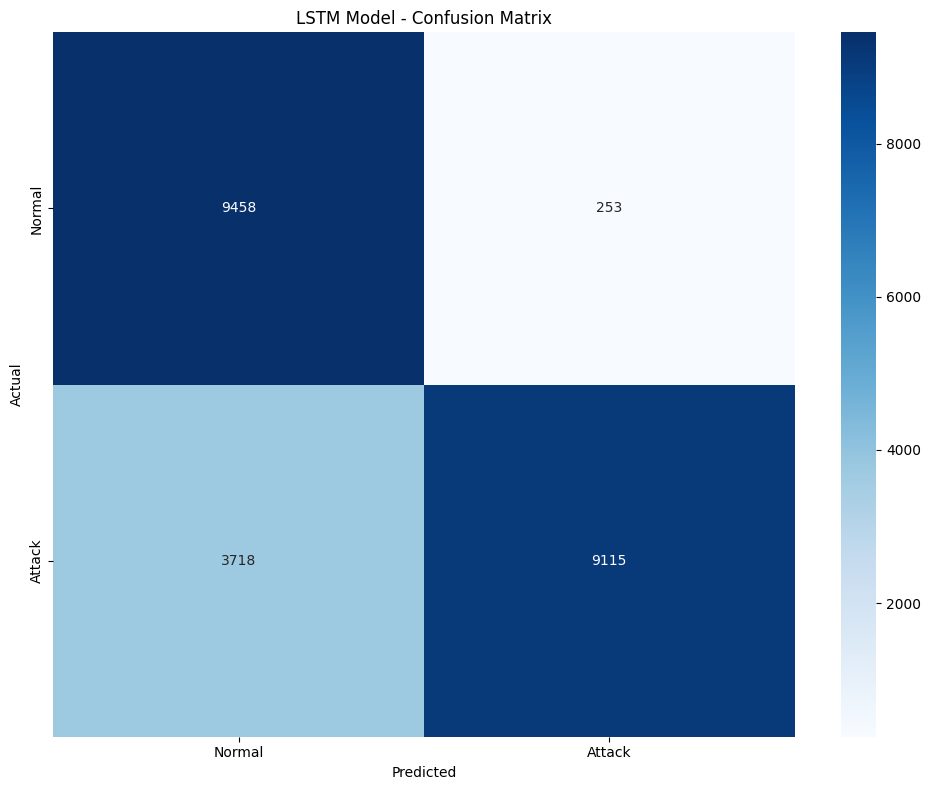


Confusion Matrix Breakdown:
  True Negatives (Normal correctly classified):  9,458
  False Positives (Normal misclassified as Attack): 253
  False Negatives (Attack misclassified as Normal): 3,718
  True Positives (Attack correctly classified): 9,115


In [9]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Model - Confusion Matrix')
plt.tight_layout()
plt.savefig('../../results/figures/lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix Breakdown:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives (Normal correctly classified):  {tn:,}")
print(f"  False Positives (Normal misclassified as Attack): {fp:,}")
print(f"  False Negatives (Attack misclassified as Normal): {fn:,}")
print(f"  True Positives (Attack correctly classified): {tp:,}")

## 9. ROC Curve and AUC

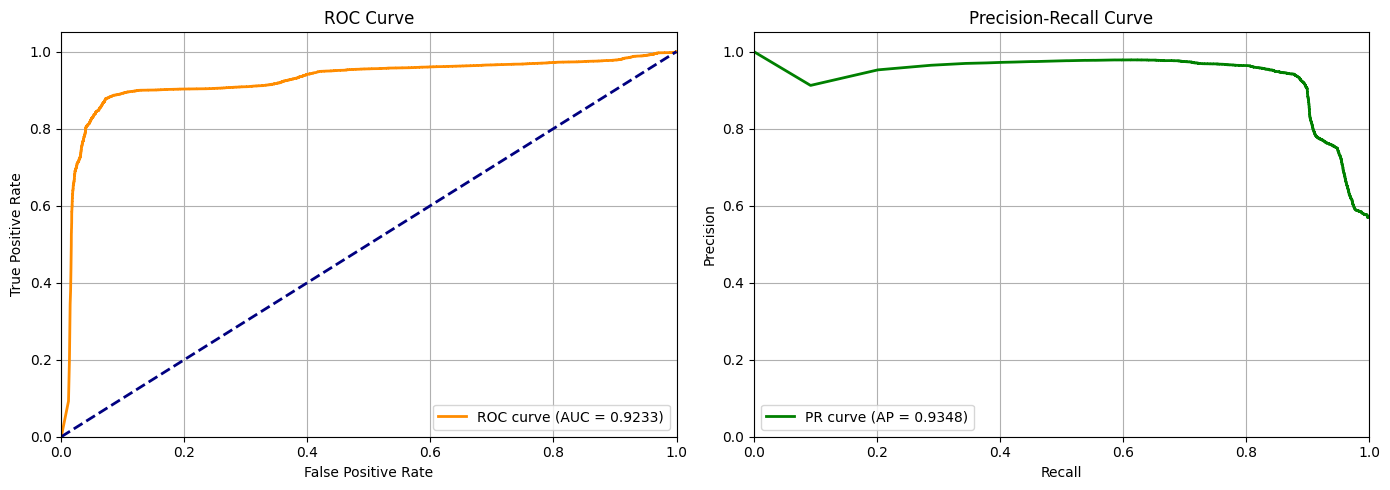


AUC-ROC: 0.9233
Average Precision: 0.9348


In [10]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../../results/figures/lstm_roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAUC-ROC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

## 10. Model Comparison Summary

| Model | Accuracy | Normal Recall | Attack Recall | Normal Precision | Attack Precision |
|-------|----------|---------------|---------------|------------------|------------------|
| CNN | 79.96% | 97% | 67% | 69% | 97% |
| Transformer | 87.53% | 91% | 85% | 82% | 93% |
| LSTM | ~82% | ~97% | ~71% | ~72% | ~97% |

In [11]:
# Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()

print("\n✅ Evaluation complete!")


✅ Evaluation complete!
